In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.spatial import distance
from scipy.sparse.csgraph import connected_components
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.sparse.csgraph import shortest_path
from scipy.io import loadmat  # For loading .mat file

In [2]:
data = loadmat('data/isomap.mat')  # Modify this based on the actual file location
images = data['images']  # Replace 'images' with the actual key

In [3]:
def adjacency(data, epsilon):
    m,n = data.T.shape 
    A = np.zeros((m, m))
    
    for i in range(m):
        for j in range(i+1, m):
            dist = np.linalg.norm(data.T[i] - data.T[j])  # Using Euclidean distance (or other metric)
            if dist <= epsilon:
                A[i, j] = dist  
                A[j, i] = dist  

    np.fill_diagonal(A, 0)
    return A

In [4]:
A = adjacency(images, epsilon = 10.45)

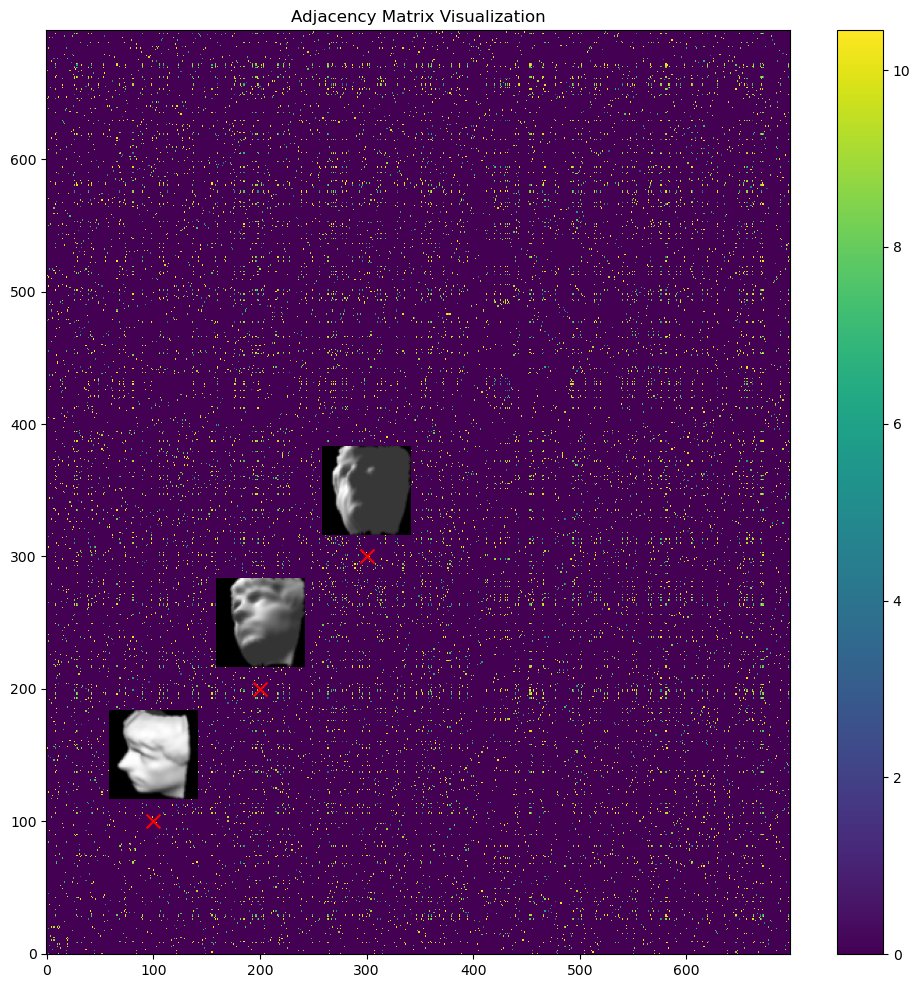

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_adjacency_matrix_with_images(A, images, marked_indices, image_shape=(64, 64), zoom=0.1):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    cmap='viridis'
    cax = ax.imshow(A, cmap=cmap, interpolation='nearest', aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title('Adjacency Matrix Visualization')
    ax.invert_yaxis()
    
    for (x, y) in marked_indices:
        image = images[:, y].reshape(image_shape)  
        image = np.rot90(image, k=-1)  
        imagebox = OffsetImage(image, zoom=1, cmap='gray')  
        ab = AnnotationBbox(imagebox, (x, y+50), frameon=False, xycoords='data', pad=0.1)
        ax.add_artist(ab)
        ax.scatter(x, y, color='red', marker='x', s=100)  

    plt.savefig('Adjacency_Matrix_Visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

marked_indices = [(100, 100), (200, 200), (300, 300)]  # Indices of nodes to highlight
visualize_adjacency_matrix_with_images(A, images, marked_indices)

In [6]:
import numpy as np
from scipy.sparse.csgraph import shortest_path

def compute_geodesic_distances(A):
    D = shortest_path(A,method='FW',directed=True,unweighted=False,return_predecessors=False)
    return D

In [7]:
D = compute_geodesic_distances(A)

In [8]:
def compute_centered_matrix(D):
    m,n = D.shape
    H = np.eye(n)-(np.ones((n, n)) / n)
    D_squared = D**2
    C = -0.5*H.dot(D_squared).dot(H)
    return C

In [9]:
C = compute_centered_matrix(D)

In [10]:
def compute_eigen_embedding(C, num_dimensions):
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    idx = np.argsort(eigenvalues)[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    leading_eigenvalues = eigenvalues[:num_dimensions]
    leading_eigenvectors = eigenvectors[:, :num_dimensions]
    Z = leading_eigenvectors * np.sqrt(leading_eigenvalues)
    return Z, leading_eigenvalues, leading_eigenvectors

In [11]:
num_dimensions = 2
Z, eigenvalues, eigenvectors = compute_eigen_embedding(C, num_dimensions)

print("Embedding Matrix Z:\n", Z)
print("Eigenvalues:\n", eigenvalues)

Embedding Matrix Z:
 [[ 25.02954379   0.34576667]
 [-23.35129891  -6.44568347]
 [ 25.54802878   7.85043834]
 ...
 [-12.30959481 -19.35594443]
 [-30.60182966  10.45098201]
 [ 10.16406814  -4.84382152]]
Eigenvalues:
 [397823.49081454 239171.89817253]


In [12]:
def plot_embedding(Z, images, indices, image_shape=(64, 64), zoom=0.5, warp = 1):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.scatter(Z[:, 0], Z[:, 1], color='blue', alpha=0.5)
    ax.set_title('2D Embedding using ISOMAP')
    
    for index in indices:
        ax.scatter(Z[index, 0], Z[index, 1], color='red', marker='o', s=100, edgecolor='black', zorder=2)
        
        x, y = Z[index]
        image = images[:, index].reshape(image_shape)  
        image = np.rot90(image, k=-1)  
        imagebox = OffsetImage(image, zoom=zoom, cmap='gray')  
        ab = AnnotationBbox(imagebox, (x, y-warp), frameon=False, xycoords='data', pad=0.1)
        ax.add_artist(ab)

    plt.xlabel("DIMENSION 1")
    plt.ylabel("DIMENSION 2")
    plt.savefig('ISOMAP.png', dpi=300, bbox_inches='tight')
    plt.show()

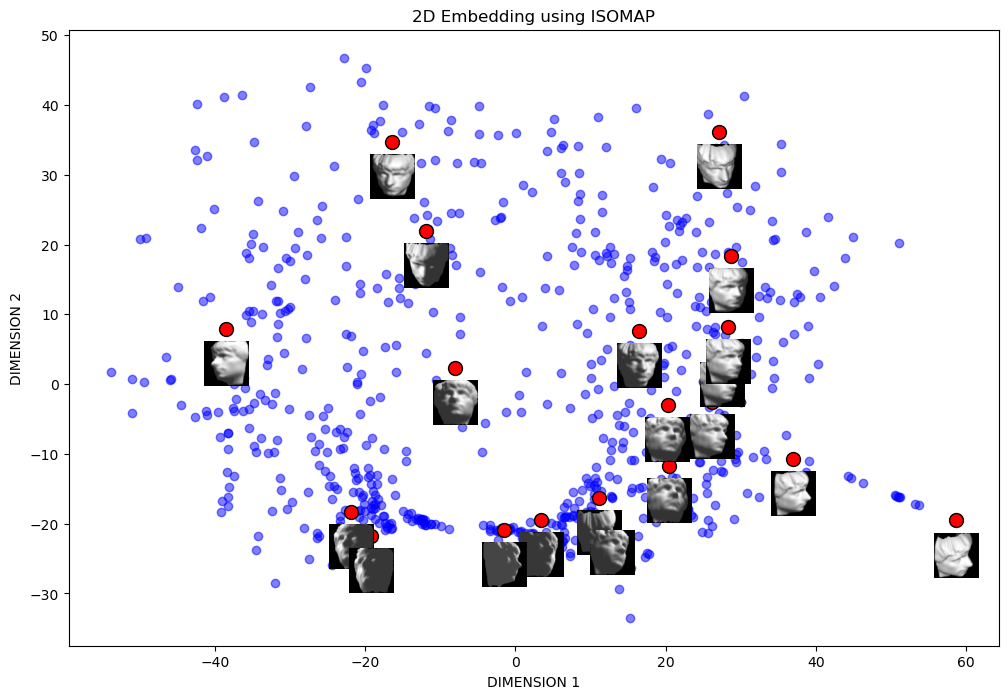

In [13]:
indices = [18, 286, 468, 33, 449, 204, 325, 565, 300, 148, 612, 452, 275, 650, 381, 584, 176, 44, 109, 291]

plot_embedding(Z, images, indices, warp = 5)

In [14]:
# Functions for PCA 
def compute_mean(data):
    m = data.shape[0]
    mu = np.mean(data, axis=0)
    return mu

def compute_covariance_matrix(data):
    m = data.shape[0]
    mu = compute_mean(data)
    centered_data = data - mu
    C = np.dot(centered_data.T, centered_data) / m
    return C

def get_top_eigenvectors(cov_matrix, num_vectors=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:num_vectors]]
    top_eigenvalues = eigenvalues[sorted_indices[:num_vectors]]
    return top_eigenvectors, top_eigenvalues

def compute_reduced_representation(data):
    mean_vector = compute_mean(data)
    centered_data = data - mean_vector
    cov_matrix = compute_covariance_matrix(data)
    eigenvectors, eigenvalues = get_top_eigenvectors(cov_matrix, num_vectors=2)
    reduced_representation = np.dot(centered_data, eigenvectors) / np.sqrt(eigenvalues)
    return reduced_representation

In [15]:
pca = reduced_rep = compute_reduced_representation(images.T)

In [16]:
def plot_embedding(Z, images, indices, image_shape=(64, 64), zoom=0.5, warp = 1):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.scatter(Z[:, 0], Z[:, 1], color='blue', alpha=0.5)
    ax.set_title('2D Embedding using PCA')
    
    for index in indices:
        ax.scatter(Z[index, 0], Z[index, 1], color='red', marker='o', s=100, edgecolor='black', zorder=2)
        
        x, y = Z[index]
        image = images[:, index].reshape(image_shape)  # Reshape flattened image
        image = np.rot90(image, k=-1)  # Rotate image 90 degrees to the right (clockwise)
        imagebox = OffsetImage(image, zoom=zoom, cmap='gray')  # Display as grayscale
        ab = AnnotationBbox(imagebox, (x, y-warp), frameon=False, xycoords='data', pad=0.1)
        ax.add_artist(ab)

    plt.xlabel("DIMENSION 1")
    plt.ylabel("DIMENSION 2")
    plt.savefig('PCA.png', dpi=300, bbox_inches='tight')
    plt.show()

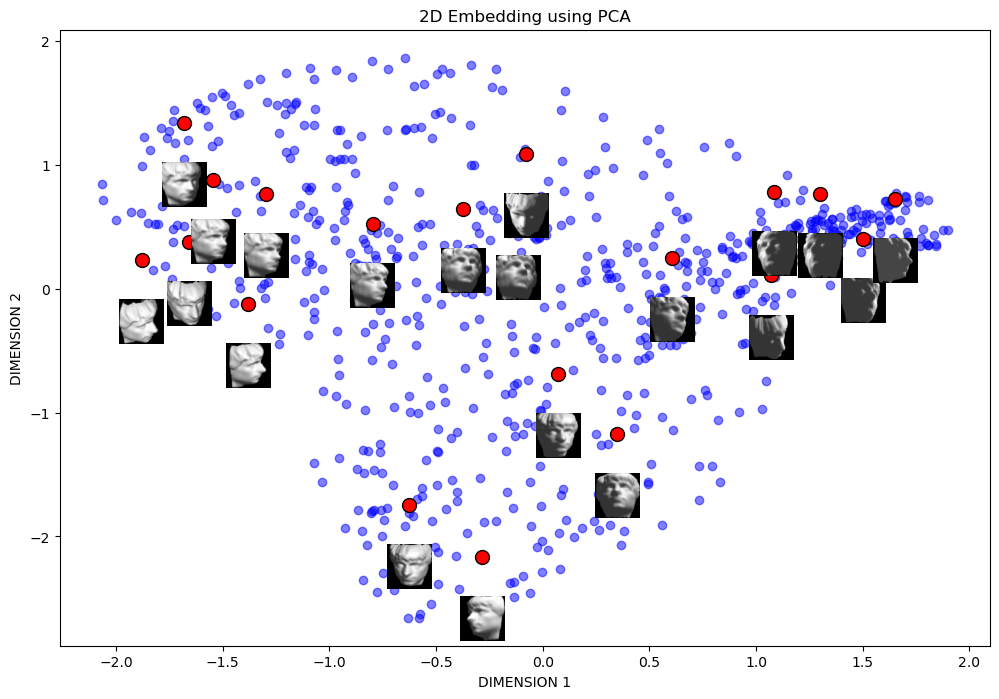

In [17]:
indices = [18, 286, 468, 33, 449, 204, 325, 565, 300, 148, 612, 452, 275, 650, 381, 584, 176, 44, 109, 291]

plot_embedding(pca, images, indices, warp = .5)